## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm, lognorm, uniform

In [2]:
print("Yfinance version: " , yf.__version__)

Yfinance version:  0.2.37


In [3]:
# Set default parameters for plt.title()
plt.rcParams['axes.titlepad'] = 12  # Set padding around the title
plt.rcParams['axes.titleweight'] = 'normal'  # Set title font size
plt.rcParams['axes.titlesize'] = 9  # Set title font size

## Fetch cotation data

In [4]:
def fetch_stock_data(tickers, start_date, end_date, interval):
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)
    return data

In [5]:
# select tickers
tickers = ["IAU", "GOOG", "MSFT", "BRK-B", "KO", "JNJ", "DG", "DIS"] #, "BRK-B", "IAU", "GOOG", "AMZN", "AAPL", "TSM", "BAC", "WFC"]  #VALE, KO, JNJ, DG, DIS, SPY 

# date format YYYY-MM-DD
start_date = "2010-01-01"
end_date = "2024-02-01"

# time interval to take the cotations, in this case monthly
interval= "1d"

stock_data = fetch_stock_data(tickers, start_date, end_date, interval)

display(stock_data)

[*********************100%%**********************]  8 of 8 completed


Price        Adj Close                                                \
Ticker           BRK-B          DG        DIS        GOOG        IAU   
Date                                                                   
2010-01-04   66.220001   20.905287  27.843178   15.610239  21.978001   
2010-01-05   66.540001   21.068327  27.773716   15.541497  21.954000   
2010-01-06   66.199997   21.358173  27.626125   15.149715  22.326000   
2010-01-07   66.459999   21.503090  27.634809   14.797037  22.181999   
2010-01-08   66.440002   21.620846  27.678217   14.994298  22.290001   
...                ...         ...        ...         ...        ...   
2024-01-25  380.850006  132.880005  94.860001  153.639999  38.230000   
2024-01-26  385.399994  133.449997  95.360001  153.789993  38.180000   
2024-01-29  383.179993  133.690002  97.489998  154.839996  38.459999   
2024-01-30  387.149994  131.919998  96.940002  153.050003  38.509998   
2024-01-31  383.739990  132.070007  96.050003  141.800003  38.490002   

Price                                               Close              ...  \
Ticker             JNJ         KO        MSFT       BRK-B          DG  ...   
Date                                                                   ...   
2010-01-04   42.650623  18.498018   23.431587   66.220001   23.080000  ...   
2010-01-05   42.156075  18.274248   23.439161   66.540001   23.260000  ...   
2010-01-06   42.498962  18.267769   23.295309   66.199997   23.580000  ...   
2010-01-07   42.195644  18.222361   23.053047   66.459999   23.740000  ...   
2010-01-08   42.340714  17.885090   23.212036   66.440002   23.870001  ...   
...                ...        ...         ...         ...         ...  ...   
2024-01-25  158.357635  59.160000  404.122681  380.850006  132.880005  ...   
2024-01-26  158.298096  59.369999  403.184418  385.399994  133.449997  ...   
2024-01-29  158.159149  59.730000  408.963715  383.179993  133.690002  ...   
2024-01-30  157.573593  59.900002  407.835815  387.149994  131.919998  ...   
2024-01-31  157.702606  59.490002  396.846130  383.739990  132.070007  ...   

Price            Open               Volume                                \
Ticker             KO        MSFT    BRK-B       DG       DIS       GOOG   
Date                                                                       
2010-01-04  28.580000   30.620001  1575000   437200  13700400   78541293   
2010-01-05  28.424999   30.850000  1310000   283600  10307700  120638494   
2010-01-06  28.174999   30.879999  1760000   968100  10709500  159744526   
2010-01-07  28.165001   30.629999  1505000   360700   8202100  257533695   
2010-01-08  27.730000   30.280001  1500000   967300   7657500  189680313   
...               ...         ...      ...      ...       ...        ...   
2024-01-25  59.009998  404.320007  4055800  2097700   8661600   21495100   
2024-01-26  59.250000  404.369995  3621400  1384200   7812800   19494500   
2024-01-29  59.340000  406.059998  3797400  2488600  13422200   20909300   
2024-01-30  59.849998  412.260010  3090900  2799300   9139600   26578900   
2024-01-31  60.099998  406.959991  3856400  1803700   9592300   43908600   

Price                                              
Ticker          IAU       JNJ        KO      MSFT  
Date                                               
2010-01-04  1185000   9506200  13870400  38409100  
2010-01-05   936000  10673100  23172400  49749600  
2010-01-06  1091000  13171500  19264600  58182400  
2010-01-07   811500  10901600  13234600  50559700  
2010-01-08   737000   7898000  28712400  51197400  
...             ...       ...       ...       ...  
2024-01-25  4637800   5478900  14899700  21021200  
2024-01-26  3288100   5591900  13025100  17803300  
2024-01-29  3503900   6483200  14547100  24510200  
2024-01-30  4125600   7200500  22061500  33477600  
2024-01-31  9428800   8256800  22837000  47871100  

[3543 rows x 48 columns]

In [6]:
# select only the closing price
df_close = stock_data.Close.copy()
df_close.info()
df_close

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3543 entries, 2010-01-04 to 2024-01-31
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BRK-B   3543 non-null   float64
 1   DG      3543 non-null   float64
 2   DIS     3543 non-null   float64
 3   GOOG    3543 non-null   float64
 4   IAU     3543 non-null   float64
 5   JNJ     3543 non-null   float64
 6   KO      3543 non-null   float64
 7   MSFT    3543 non-null   float64
dtypes: float64(8)
memory usage: 249.1 KB


Ticker,BRK-B,DG,DIS,GOOG,IAU,JNJ,KO,MSFT
Date,,,,,,,,
2010-01-04,66.220001,23.080000,32.070000,15.610239,21.978001,64.680000,28.520000,30.950001
2010-01-05,66.540001,23.260000,31.990000,15.541497,21.954000,63.930000,28.174999,30.959999
2010-01-06,66.199997,23.580000,31.820000,15.149715,22.326000,64.449997,28.165001,30.770000
2010-01-07,66.459999,23.740000,31.830000,14.797037,22.181999,63.990002,28.094999,30.450001
2010-01-08,66.440002,23.870001,31.879999,14.994298,22.290001,64.209999,27.575001,30.660000
...,...,...,...,...,...,...,...,...
2024-01-25,380.850006,132.880005,94.860001,153.639999,38.230000,159.559998,59.160000,404.869995
2024-01-26,385.399994,133.449997,95.360001,153.789993,38.180000,159.500000,59.369999,403.929993
2024-01-29,383.179993,133.690002,97.489998,154.839996,38.459999,159.360001,59.730000,409.720001


## Calculate returns

### Year-over-Year Return (YoY)

In [7]:
returns_daily = (df_close
                 .copy()
                 .pct_change(periods=252)
                 .dropna()
)

# display(returns_daily.describe())
returns_daily.head(3)

Ticker,BRK-B,DG,DIS,GOOG,IAU,JNJ,KO,MSFT
Date,,,,,,,,
2011-01-03,0.214286,0.328856,0.179295,-0.035740,0.257621,-0.028757,0.143408,-0.095961
2011-01-04,0.204839,0.312984,0.218818,-0.035049,0.229844,-0.009072,0.133452,-0.092700
2011-01-05,0.222206,0.276506,0.255814,0.001332,0.205769,-0.017688,0.127108,-0.090023


## Fit distribution model - Returns

In [8]:
def calculate_return_params(key):
    sigma, loc, scale = lognorm.fit(returns_daily[key] + 1.0)    
    return (sigma, loc, scale)

In [9]:
# Defining return dict to receive the fitting parameters from distributions
params = ("sigma", "loc", "scale")
return_fitting_params_lognormal = { key: dict( zip( params, calculate_return_params(key)) ) for key in tickers }

In [10]:
# return_fitting_params_lognormal

## Return plots

### Lognormal:

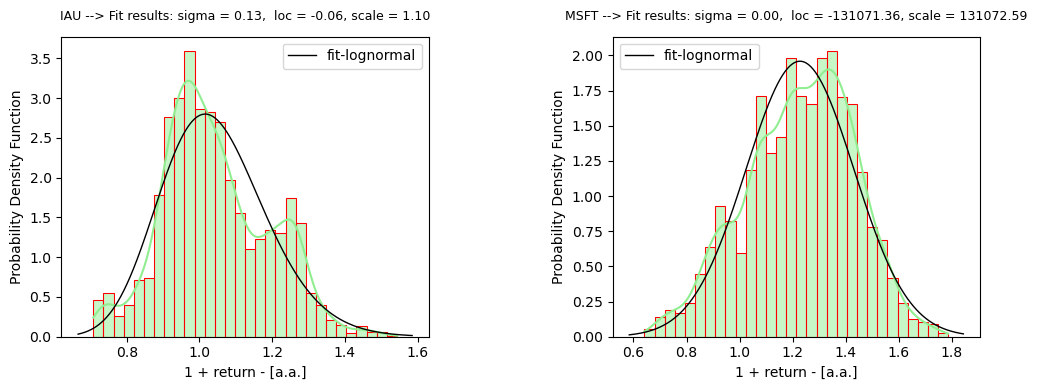

In [11]:
# Plot the histogram of the returns_daily along with the fitted Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
tick0 = tickers[0]
tick1 = tickers[2]
# Fit a Gaussian distribution to the returns_daily
plt.subplot(1, 2, 1)
data = returns_daily[tick0] + 1.0
sns.histplot(data= data, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = lognorm.pdf(x, return_fitting_params_lognormal[tick0]["sigma"], loc= return_fitting_params_lognormal[tick0]["loc"], scale= return_fitting_params_lognormal[tick0]["scale"])

plt.plot(x, p, 'k', label="fit-lognormal", linewidth=1)
plt.title(f"{tick0} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (return_fitting_params_lognormal[tick0]["sigma"],
                                                                                      return_fitting_params_lognormal[tick0]["loc"],
                                                                                      return_fitting_params_lognormal[tick0]["scale"]))
plt.ylabel("Probability Density Function")
plt.xlabel("1 + return - [a.a.]")
plt.legend()


# Fit a Gaussian distribution to the returns_daily
plt.subplot(1, 2, 2)
data = returns_daily[tick1] + 1.0
sns.histplot(data= data, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='red')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = lognorm.pdf(x, return_fitting_params_lognormal[tick1]["sigma"], loc= return_fitting_params_lognormal[tick1]["loc"], scale= return_fitting_params_lognormal[tick1]["scale"])

plt.plot(x, p, 'k', label="fit-lognormal", linewidth=1)
plt.title(f"{tick1} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (return_fitting_params_lognormal[tick1]["sigma"],
                                                                                      return_fitting_params_lognormal[tick1]["loc"],
                                                                                      return_fitting_params_lognormal[tick1]["scale"]))
plt.ylabel("Probability Density Function")
plt.xlabel("1 + return - [a.a.]")
plt.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

## Generate samples from distributions models

In [12]:
# Number of samples
num_samples = 1_000

In [13]:
def calculate_return_samples(ticker, num_samples=1_000):
    sigma   = return_fitting_params_lognormal[ticker]["sigma"]
    loc     = return_fitting_params_lognormal[ticker]["loc"]
    scale   = return_fitting_params_lognormal[ticker]["scale"]
    samples = lognorm.rvs(sigma, loc=loc, scale=scale, size=num_samples) - 1.0
    return samples

# Defining return dict to receive the samples from distributions models builted with their respective parameters
return_samples_lognormal = { ticker: calculate_return_samples(ticker, num_samples) for ticker in tickers }


## Plot - Compare data vs model

### Returns:

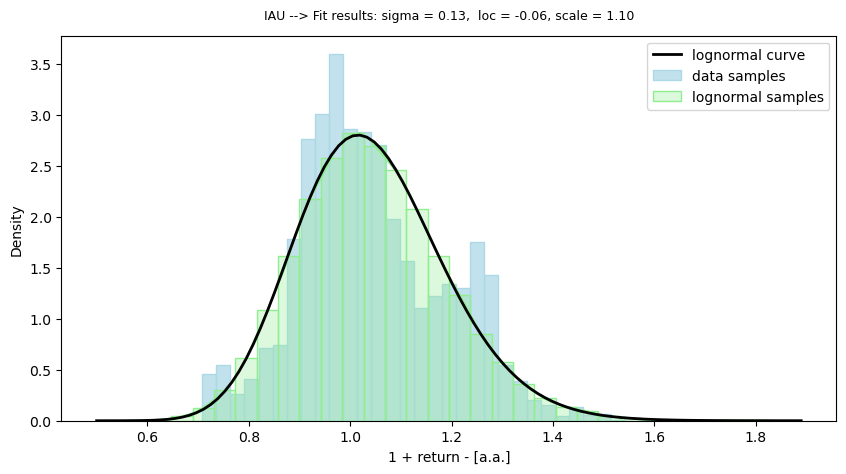

In [14]:
# Find the best parameters when fitting the model to the data
data = returns_daily[tickers[0]] + 1.0
sigma, loc, scale = lognorm.fit(data)

# Generate samples based on the parameters find previously
n_samples = 100_000
samples = lognorm.rvs(sigma, loc=loc, scale=scale, size=n_samples)

# Plot the histogram of the generated samples
plt.figure(figsize=(10,5))
sns.histplot(data, bins=30, stat="density", color='lightblue', edgecolor='lightblue', label="data samples")
sns.histplot(samples, bins=30, stat="density", kde=True, color='lightgreen', edgecolor='lightgreen', alpha=0.3, label="lognormal samples")

# Plot the PDF of the lognormal distribution for comparison
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = lognorm.pdf(x, sigma, loc= loc, scale= scale)

plt.plot(x, pdf, 'k', linewidth=2, label="lognormal curve")
plt.title(f"{tickers[0]} --> Fit results: sigma = %.2f,  loc = %.2f, scale = %.2f" % (sigma, loc, scale))
plt.ylabel("Density")
plt.xlabel("1 + return - [a.a.]")
plt.legend()
plt.show()

## Monte carlo simulation

### Equations:
<br>

- **Portfolio Return**:
<br>
$$ R_P = {\omega}^T \cdot R $$
<br>
with $R_P$ being the return of the portfolio, $\omega$ the weights and $R$ the returns of the assets. Each one are given by:
<br><br>

<table>
  <tr>
    <td>
      $$
        \omega = \begin{bmatrix}
                {\omega}_A \\
                {\omega}_B \\
                {\omega}_C \\
        \end{bmatrix},
      $$
    </td>
    <td>
      and
    </td>
    <td>
    $$
        R = \begin{bmatrix}
                R_A \\
                R_B \\
                R_C \\
        \end{bmatrix}.
    $$
    </td>
  </tr>
</table>

<br>

- **Portfolio Risk**: 
<br>
$$ {{\sigma}^2_P} = {\omega}^T \cdot \Sigma \cdot \omega $$
<br>
in wich ${{\sigma}^2_P}$ is the variance of the portfolio and $\Sigma$ is the covariance matrix of the assets. The covariance matrix is given by:
<br>
<br>
$$ \Sigma = \begin{bmatrix}
                {{\sigma}^2_A} & cov(A,B) & cov(A,C) \\
                cov(A,B) & {{\sigma}^2_B} & cov(B,C) \\
                cov(A,C) & cov(B,C) & {{\sigma}^2_C} \\
            \end{bmatrix}.
$$
<br>




## Generate asset weights

In [15]:
def make_wight_matrix(n_tickers, n_samples=1_000):
    rand_values = uniform.rvs(size= int(n_tickers * n_samples)).reshape((n_tickers, n_samples))
    normalized_values = rand_values / rand_values.sum(axis=0, keepdims=True)
    return normalized_values

# Matrix of the weights
weight_matrix = make_wight_matrix(len(tickers), num_samples)
weight_matrix.shape

(8, 1000)

## Build Assets Return Matrix

In [16]:
# Create empty array with the final shape
assets_return_matrix = np.zeros((len(tickers), num_samples), dtype=np.float64)

# Map the values in the dictionary to the new array
for row, ticker in zip(range(len(tickers)), tickers):
    assets_return_matrix[row, :] = return_samples_lognormal[ticker].reshape(1, num_samples)

assets_return_matrix[:, :5]

array([[-0.31910476, -0.059791  ,  0.16980302, -0.10117072,  0.22888906],
       [ 0.19967007,  0.20341698,  0.54430636,  0.4533716 , -0.10996732],
       [ 0.48861661,  0.00892681,  0.59382244,  0.02429302,  0.35531157],
       [-0.01220381,  0.09798832,  0.00486489,  0.34828152,  0.50443651],
       [ 0.06616808,  0.12955617,  0.09077525,  0.17959527,  0.01161799],
       [-0.04490906,  0.17314315,  0.187347  ,  0.30512082,  0.0566717 ],
       [ 0.08653846,  0.69379147,  0.59023059,  0.20793294,  0.04946662],
       [ 0.19782192,  0.17539273,  0.14143513,  0.06503318, -0.14019236]])

## Portfolio Return

In [17]:
# # Matrix of the returns
portfolio_return = weight_matrix.T.dot(assets_return_matrix).reshape(-1)
portfolio_return.shape

(1000000,)

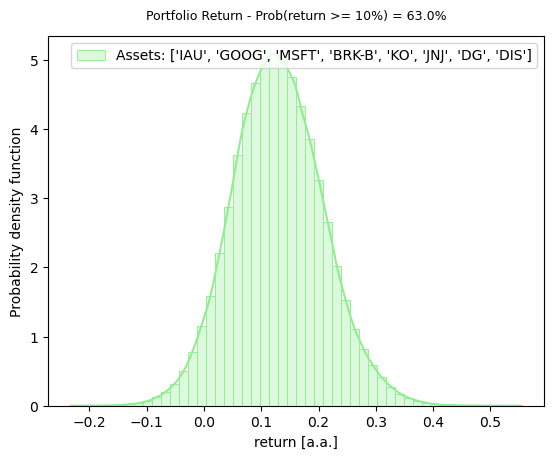

In [18]:
# Plot
sns.histplot(portfolio_return, bins=50, stat="density", kde=True, color='lightgreen', edgecolor='lightgreen', alpha=0.3, label=f"Assets: {tickers}")

threshold = 0.1
return_threshold = np.count_nonzero(portfolio_return > threshold) / np.max(portfolio_return.shape)

plt.title(f"Portfolio Return - Prob(return >= {int(threshold * 100)}%) = {int(100 * return_threshold)}.0%")
plt.ylabel("Probability density function")
plt.xlabel("return [a.a.]")
plt.legend(loc="upper right")
plt.show()